In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
import pandas as pd
import os
import pickle
import re
import torchaudio.transforms as T
import math
import librosa
import librosa.display
import matplotlib.patches as patches

torch.manual_seed(1)

In [25]:
datapath = '/project/graziul/data/whitelisted_vad_files.csv'
dataframe = pd.read_csv(datapath, header=None)

transcripts_path = '/project/graziul/transcripts/transcripts2021_10_27.csv'
transcripts_df = pd.read_csv(transcripts_path)
new_filename_list = []
chars_to_remove = ['_','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','.']
#chars_to_remove = 'abcdefghijklmnopqrstuvwxyz.'
for idx,elt in enumerate(list(transcripts_df['file'])):
    my_elt = elt.lower()
    for char in chars_to_remove:
        my_elt = my_elt.replace(char,"")
    new_filename_list.append(my_elt + '.mp3')
new_filename_list = list(set(new_filename_list))

222

In [ ]:
zone_paths = '/project/graziul/data/Zone'
for file in new_filename_list:
    for i in range(14):
        zone_path = zone_paths + str(i) + '/'
        if(os.path.exists(zone_paths) + file):
            

In [32]:
for r_name, d_name, f_name in os.walk('/project/graziul/data/'):
    print(r_name, d_name, f_name)

/project/graziul/data/ ['Zone11', 'Zone2', 'Zone12', 'Zone8', 'Zone6', 'Zone1', 'corpora', 'CPD', 'Zone13', 'Zone5', 'Zone10', 'Zone3', 'Zone4'] ['whitelisted_vad_files.csv', 'ProjectiveNum2.wav', 'projectives2021_09_07.txt', 'ProjectiveNum4.wav', '.Rhistory', 'ProjectiveNum3.wav', 'ProjectiveNum1.wav', '.RData', 'ProjectiveNum5.wav']
/project/graziul/data/Zone11 ['2019_07_09', '2019_02_18', '2019_04_18', '2019_05_17', '2019_02_12', '2019_06_04', '2019_07_04', '2019_01_09', '2019_01_21', '2018_08_29', '2018_08_08', '2018_11_18', '2018_12_31', '2019_06_05', '2018_09_08', '2019_07_21', '2018_11_22', '2019_04_19', '2019_01_26', '2018_11_02', '2018_12_09', '2018_12_21', '2018_12_07', '2019_03_16', '2019_03_27', '2018_10_11', '2018_09_09', '2019_05_03', '2018_12_11', '2018_09_30', '2018_12_24', '2018_09_11', '2018_09_29', '2019_04_12', '2018_12_23', '2019_04_13', '2019_02_01', '2018_10_09', '2019_03_12', '2019_07_23', '2018_09_22', '2019_04_05', '2018_11_15', '2018_08_17', '2018_11_10', '20

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
file = open('/project/graziul/data/Zone1/2018_08_04/2018_08_04vad_dict.pkl','rb')
vad_dict = pickle.load(file)

In [33]:
test_key = list(vad_dict.keys())[0]
vad_dict[test_key]

{'pydub': {-24: {'nonsilent_slices': [[392854, 394170],
    [395263, 395267],
    [397620, 398701],
    [399578, 409655],
    [410254, 410656],
    [411215, 411220],
    [414952, 416884],
    [418455, 418461],
    [824867, 825037],
    [825665, 826898],
    [828423, 828427],
    [829500, 830273],
    [830861, 838611],
    [839113, 842452],
    [843753, 843953],
    [845021, 845763],
    [846627, 850160],
    [850738, 851675],
    [852412, 853170],
    [853794, 855787],
    [856386, 858849],
    [859979, 859982],
    [867465, 868866],
    [870249, 871474],
    [872242, 873340],
    [874666, 874864],
    [875933, 879834],
    [880956, 880960],
    [1631361, 1633400],
    [1634783, 1634786],
    [1635967, 1638723],
    [1639276, 1639316],
    [1640028, 1644938],
    [1646046, 1649121],
    [1650149, 1650152]],
   'nonsilent_minutes': 0.9895676492819349}}}

In [34]:
t = a.get_mfcc()
t.size()

torch.Size([1, 40387392]) 22050


torch.Size([1, 40, 180410])

In [44]:
def divide_audio(datafile, div_size = 30): #Divide the audio clip into bits of 1 minute each
#resizes input arrays from (1,feature_length, time) to (div_size,feature_length,time/div_length)
    return np.reshape(datafile,[div_size,datafile.shape[1],datafile.shape[2]//div_size])

class audio_file():
    def __init__(self, name):
        self.name = name
        self.vad_slices = None
        self.frames = None
        self.frames_labels = None
        self.mfcc = None
        self.n_clips = 30
    
    def get_slices(self, vad_dict):
        self.vad_slices = vad_dict[self.name]['pydub'][-24]['nonsilent_slices']
        return self.vad_slices
    
    def get_frames(self):
        ms_2_sample = self.sample_rate/1000
        frames_array = np.zeros(self.mfcc.shape[2])
        print(frames_array.shape)
        #frames_array = np.zeros(180409)

        for v in self.vad_slices:
            start = math.floor(v[0]*ms_2_sample)
            end = math.ceil(v[1]*ms_2_sample)
            #print(v)
            for i in range(start,end):
                n = math.floor(i/220)
                j = i%220
                if j <= 110:
                    frames_array[n-2] += 1
                    frames_array[n-1] += 1
                    frames_array[n] += 1
                elif j>=111 and j<=220:
                    frames_array[n-1] += 1
                    frames_array[n] += 1
                elif j>=221 and j<=330:
                    frames_array[n-1] += 1
                    frames_array[n] += 1
                    frames_array[n+1] += 1
                elif j>=331 and j<=440:
                    frames_array[n+1] += 1
                    frames_array[n] += 1
                elif j>=441:
                    frames_array[n+2] += 1
                    frames_array[n+1] += 1
                    frames_array[n] += 1
            
        self.frames = frames_array
        return self.frames
        
    def get_split_frames(self):
        '''ms_2_sample = self.sample_rate/1000
        frame_arr_list = []
        for j in range(self.n_clips):
            frames_array = np.zeros(self.mfcc.shape[2])
            #frames_array = np.zeros(180409)
            self.clip_size = self.mfcc.shape[2]
            start_idx = j*self.clip_size
            end_idx = j*self.clip_size
            print(start_idx, end_idx)
            for v in self.vad_slices:
                start = math.floor(v[0]*ms_2_sample)
                end = math.ceil(v[1]*ms_2_sample)
                if(start >= start_idx and end <= end_idx):
                    for i in range(start,end):
                        n = math.floor(i/220)
                        j = i%220
                        if j <= 110:
                            frames_array[n-2] += 1
                            frames_array[n-1] += 1
                            frames_array[n] += 1
                        elif j>=111 and j<=220:
                            frames_array[n-1] += 1
                            frames_array[n] += 1
                        elif j>=221 and j<=330:
                            frames_array[n-1] += 1
                            frames_array[n] += 1
                            frames_array[n+1] += 1
                        elif j>=331 and j<=440:
                            frames_array[n+1] += 1
                            frames_array[n] += 1
                        elif j>=441:
                            frames_array[n+2] += 1
                            frames_array[n+1] += 1
                            frames_array[n] += 1
            frame_arr_list.append(np.expand_dims(frames_array,axis = 0))        
        self.frames = np.concatenate(frame_arr_list,axis = 0)
        return self.frames'''
        ms_2_sample = self.sample_rate/1000
        frames_array = np.zeros(self.mfcc.shape[2]*self.n_clips)
        print(frames_array.shape)
        #frames_array = np.zeros(180409)

        for v in self.vad_slices:
            start = math.floor(v[0]*ms_2_sample)
            end = math.ceil(v[1]*ms_2_sample)
            for i in range(start,end):
                n = min(math.floor(i/220),len(frames_array)-1)
                j = i%220
                if j <= 110:
                    frames_array[n-2] += 1
                    frames_array[n-1] += 1
                    frames_array[n] += 1
                elif j>=111 and j<=220:
                    frames_array[n-1] += 1
                    frames_array[n] += 1
                elif j>=221 and j<=330:
                    frames_array[n-1] += 1
                    frames_array[n] += 1
                    frames_array[n+1] += 1
                elif j>=331 and j<=440:
                    frames_array[n+1] += 1
                    frames_array[n] += 1
                elif j>=441:
                    frames_array[n+2] += 1
                    frames_array[n+1] += 1
                    frames_array[n] += 1
        
        self.clip_size = self.mfcc.shape[2]
        frame_arr_list = []
        for j in range(self.n_clips):
            frame_arr_list.append(np.expand_dims(frames_array[j*self.clip_size:(j+1)*self.clip_size],axis=0))
        self.frames = np.concatenate(frame_arr_list,axis=0)
        return self.frames
    
        
    def get_labels(self): 
        self.frames_labels = np.zeros(len(self.frames))
        self.frames_labels[np.where(self.frames>0)] = 1
        return self.frames_labels
    
    def get_split_labels(self):
        self.frames_labels = np.zeros_like(self.frames)
        self.frames_labels[np.where(self.frames>0)] = 1
        return self.frames_labels
        
    def get_mfcc(self): 
        file_name = '/project/graziul/data/Zone1/2018_08_04/' + self.name
        self.waveform, self.sample_rate = torchaudio.load(file_name)
        self.waveform = self.waveform[:,:1800*self.sample_rate] #Clip the file at 1800s
        n_fft = 2048
        win_length = 551
        hop_length = 220
        n_mels = 40
        n_mfcc = 40

        mfcc_transform = T.MFCC(
            sample_rate=self.sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
              'n_fft': n_fft,
              'n_mels': n_mels,
              'hop_length': hop_length,
              'mel_scale': 'htk',
            }
        )

        self.mfcc = mfcc_transform(self.waveform)
        return self.mfcc
    
    def get_split_mfcc(self):
        file_name = '/project/graziul/data/Zone1/2018_08_04/' + self.name
        self.waveform, self.sample_rate = torchaudio.load(file_name)
        self.waveform = self.waveform[:,:1800*self.sample_rate] #Clip the file at 1800s
        clip_size = math.floor(self.waveform.shape[1]/self.n_clips)
        n_clips = self.n_clips
        mfcc_list = []
        n_fft = 2048
        win_length = 551
        hop_length = 220
        n_mels = 40
        n_mfcc = 40
        mfcc_transform = T.MFCC(
                sample_rate=self.sample_rate,
                n_mfcc=n_mfcc,
                melkwargs={
                  'n_fft': n_fft,
                  'n_mels': n_mels,
                  'hop_length': hop_length,
                  'mel_scale': 'htk',
                }
            )
        for i in range(n_clips):
            mfcc_list.append(mfcc_transform(self.waveform[:,i*clip_size:(i+1)*clip_size]))
        self.mfcc = torch.cat(mfcc_list)
        return self.mfcc
    
    def plot_waveform_with_labels(self,i,clip_size):
        plt.figure(figsize=(14,5))
        fig,(ax1,ax2) = plt.subplots(2,1)
        librosa.display.waveshow(self.waveform.squeeze().numpy()[i*clip_size:(i+1)*clip_size],self.sample_rate,ax = ax1)
        ax2.plot(self.frames_labels[i])
        plt.show()
        return    
    
    def get_plots(self): 
        clip_size = math.floor(1800*self.sample_rate/self.n_clips)
        for i in range(self.n_clips):
            print(i)
            self.plot_waveform_with_labels(i,clip_size)
        return

In [7]:
a = audio_file(test_key)
a.get_slices(vad_dict)
test_mfcc = (a.get_split_mfcc())
a.get_split_frames()
test_labels2= (a.get_split_labels())
a.get_plots()

NameError: name 'test_key' is not defined

In [166]:
input_list = []
labels_list = []

for idx,key in enumerate(vad_dict):
    print(idx)
    if(idx == 1):
        break
    a = audio_file(key)
    a.get_slices(vad_dict)
    input_list.append(a.get_split_mfcc()) #180409
    a.get_split_frames()
    labels_list.append(a.get_split_labels()) #180409
    #a.get_plots()
input_list = torch.cat(input_list)
input_list = torch.transpose(input_list,1,2)
labels_list = torch.from_numpy(np.concatenate(labels_list,axis = 0)).float()
print(input_list.size())
print(labels_list.size())

0
(180420,)
1
torch.Size([30, 6014, 40])
torch.Size([30, 6014])


In [25]:
np.any(labels_list.numpy() == 1.)

True

In [ ]:
f = '/project/graziul/ra/anishk/VAD/Source/Data/data1.pt'
data = torch.load(f)
data = np.transpose(data, (0, 2, 1))

In [ ]:
data.shape

# Initialize LSTM
Pytorch’s LSTM expects all of its inputs to be 3D tensors. The semantics of the axes of these tensors is important. The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input. 

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
input_dim = 40
hidden_dim = 64 
n_layers = 3 

lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

batch_size = 1

hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

out, hidden = lstm(data, hidden)

In [ ]:
def temp_attention(hidden_feature_map):
    H_maxtemp = torch.max(hidden_feature_map, 1).values
    H_avgtemp = torch.mean(hidden_feature_map, 1)
    H_stdtemp = torch.std(hidden_feature_map, 1)
    H_concattemp = torch.cat([H_maxtemp[None, :], H_avgtemp[None, :], H_stdtemp[None,:]], dim=0)
    return H_concattemp

def freq_attention(hidden_feature_map):
    H_maxfreq = torch.max(hidden_feature_map, 0).values
    H_avgfreq = torch.mean(hidden_feature_map, 0)
    H_stdfreq = torch.std(hidden_feature_map, 0)
    H_concatfreq = torch.cat([H_maxfreq[None, :], H_avgfreq[None, :], H_stdfreq[None,:]], dim=0)
    return H_concatfreq 

def convolve(input,H):
    # Define normalization and relu functions for use after first 3 convolutions
    norm = nn.BatchNorm1d(64, affine=False, track_running_stats=False)
    ReLU = nn.ReLU()

    # 1D Convolution; padding of 5 on both sides to account for ndims change
    conv1 = nn.Conv1d(3,3, kernel_size=11, padding=5)
    output = conv1(input)
    output = norm(output)
    output = ReLU(output)
    
    conv2 = nn.Conv1d(3,5, kernel_size=11, padding=5)
    input = output
    output = conv2(input)
    output = norm(output)
    output = ReLU(output)
    
    conv3 = nn.Conv1d(5,5, kernel_size=11, padding=5)
    input = output
    output = conv3(input)
    output = norm(output)
    output = ReLU(output)
    
    conv4 = nn.Conv1d(5,1, kernel_size=11, padding=5)
    input = output
    H_temp = conv4(input)
    # "Expand/copy" output of last layer (H_temp) to same dims as H
    H_temp = H_temp.expand(-1,64,-1)
    # Sigmoid activation     
    sigmoid = nn.Sigmoid()
    input = H_temp
    H_temp = sigmoid(input)
    H_temp = torch.transpose(H_temp, 1, 2)[0]
    # Merge H_temp and H by element wise summation
    H_prime = torch.stack((H,H_temp))
    H_prime = torch.sum(H_prime,0)
    return H_prime

#H = out[0] ##H is the "Hidden feature map"
#input = temp_attention(H)[None,:] ## batch_size, channels, features
#output = convolve(input,H)

In [ ]:
def display(tensor):
    input = tensor.detach().numpy()
    a = plt.hist(input[0][0], bins = 50)
    b = plt.hist(input[0][1], bins = 50)
    c = plt.hist(input[0][2], bins = 50)
    plt.show()
    d = print('max:',np.max(input))
    e = print('min:',np.min(input))
    range = np.max(input)-np.min(input)
    f = print('range:',range)
    return 

In [ ]:
H = out[0] ##H is the "Hidden feature map"
input = temp_attention(H)[None,:] ## batch_size, channels, features

# Define normalization and relu functions for use after first 3 convolutions
norm = nn.BatchNorm1d(64, affine=False, track_running_stats=False)
ReLU = nn.ReLU()

# 1D Convolution; padding of 5 on both sides to account for ndims change
conv1 = nn.Conv1d(3,3, kernel_size=11, padding=5)
output = conv1(input)
output = norm(output)
output = ReLU(output)

conv2 = nn.Conv1d(3,5, kernel_size=11, padding=5)
input = output
output = conv2(input)
output = norm(output)
output = ReLU(output)


conv3 = nn.Conv1d(5,5, kernel_size=11, padding=5)
input = output
output = conv3(input)
output = norm(output)
output = ReLU(output)

conv4 = nn.Conv1d(5,1, kernel_size=11, padding=5)
input = output
H_temp = conv4(input)
# "Expand/copy" output of last layer (H_temp) to same dims as H
H_temp = H_temp.expand(-1,64,-1)
# Sigmoid activation     
sigmoid = nn.Sigmoid()
input = H_temp
H_temp = sigmoid(input)
H_temp = torch.transpose(H_temp, 1, 2)[0]
# Merge H_temp and H by element wise summation
H_prime = torch.stack((H,H_temp))
H_prime = torch.sum(H_prime,0)
display(H_temp)

In [ ]:
# Same parameters as LSTM1 except for input dim

output = output[0,:,:,:]
output = torch.transpose(output,1,2)
input_dim = 5
hidden_dim = 64 
n_layers = 3 

lstm2 = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

batch_size = 1

hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

out, hidden = lstm2(output, hidden)

In [ ]:
print(out.size())

In [ ]:
linear1 = nn.Linear(64, 64)
linear1_output = linear1(out)

linear2 = nn.Linear(64, 1)
linear2_output = linear2(linear1_output)

sigmoid = nn.Sigmoid()
input = linear2_output
output_binary = sigmoid(input)

In [ ]:
input = 

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer.zero_grad()
loss_fn(model(input), target).backward()
optimizer.step()

In [168]:
class StackedLSTM(nn.Module):
    def __init__(self):
        super(StackedLSTM, self).__init__()
        self.input_dim1 = 40
        self.input_dim2 = 64 
        self.hidden_dim = 64
        self.n_layers = 3
        self.batch_size = 2
        #(input is of format batch_size, sequence_length, num_features)
        #hidden states should be (num_layers, batch_size, hidden_length)
        self.hidden_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.cell_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.hidden_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.cell_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.lstm1 = nn.LSTM(input_size = self.input_dim1, hidden_size = self.hidden_dim, num_layers = self.n_layers, batch_first=True) #should be True
        self.lstm2 = nn.LSTM(input_size = self.input_dim2, hidden_size = self.hidden_dim, num_layers = self.n_layers, batch_first=True) #should be True
        self.lstm2_out = None 
        self.hidden = None
        #self.flatten = nn.Flatten()
        self.convolve1d = nn.Sequential(
            nn.Conv1d(3,3, kernel_size=11, padding=5),
            nn.BatchNorm1d(64, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv1d(3,5, kernel_size=11, padding=5),
            nn.BatchNorm1d(64, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv1d(5,5, kernel_size=11, padding=5),
            nn.BatchNorm1d(64, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv1d(5,1, kernel_size=11, padding=5)
        )
        self.output_stack = nn.Sequential(
            nn.Linear(64, 64),
            nn.Linear(64, 1)
        )
        self.sigmoid = nn.Sigmoid()

#     def create_rand_hidden1(self):
#         self.hidden_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
#         self.cell_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
#         return (self.hidden_state1, self.cell_state1)

    def temp_attention(self, data):
        #hn = self.hidden_state1
        #cn = self.cell_state1
        #for idx in range(data.size()[1]):
        #    output, (hn,cn) = self.lstm1(torch.unsqueeze(data[:,idx,:],1), (hn,cn))
        H, hidden = self.lstm1(data, (self.hidden_state1, self.cell_state1)) 
        #H = output
        #hidden = (hn,cn)
        H_maxtemp = torch.unsqueeze(torch.max(H, -1).values,2)
        H_avgtemp = torch.unsqueeze(torch.mean(H, -1),2)
        H_stdtemp = torch.unsqueeze(torch.std(H, -1),2)
        H_concattemp = torch.cat([H_maxtemp, H_avgtemp,H_stdtemp], dim=2)
        H_concattemp = torch.transpose(H_concattemp, 1,2)
        return H_concattemp,H 
    
    def convolve1(self, data):
        H_concattemp,H = self.temp_attention(data)
        H_temp = self.convolve1d(H_concattemp)
        # "Expand/copy" output of last layer (H_temp) to same dims as H
        H_temp = H_temp.expand(-1,64,-1)
        # Sigmoid activation     
        sigmoid = nn.Sigmoid()
        my_input = H_temp
        H_temp = sigmoid(my_input)
        H_temp = torch.transpose(H_temp, 1, 2)
        # Merge H_temp and H by element wise summation
        H_prime = torch.stack((H,H_temp))
        H_prime = torch.sum(H_prime,0)
        return H_prime
        
#     def create_rand_hidden2(self):
#         self.hidden_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
#         self.cell_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
#         return (self.hidden_state2, self.cell_state2)  
    
#     def freq_attention(hidden_feature_map):
#         H_maxfreq = torch.max(hidden_feature_map, 0).values
#         H_avgfreq = torch.mean(hidden_feature_map, 0)
#         H_stdfreq = torch.std(hidden_feature_map, 0)
#         H_concatfreq = torch.cat([H_maxfreq[None, :], H_avgfreq[None, :], H_stdfreq[None,:]], dim=0)
#         return H_concatfreq 

    def forward(self, data):
        input1 = self.convolve1(data)
        #print(input1.size())
        #hn = self.hidden_state2
        #cn = self.cell_state2
        #for idx in range(input1.size()[1]):
        #    output, (hn,cn) = self.lstm2(torch.unsqueeze(input1[:,idx,:],1), (hn,cn))
        #lstm2_out = output
        #hidden = (hn,cn)
        lstm2_out, hidden = self.lstm2(input1, (self.hidden_state2, self.cell_state2))
        self.output = self.output_stack(lstm2_out)
        print(self.output)
        self.output = torch.squeeze(self.output)
        return self.output
        

In [169]:
class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.input_dim1 = 40
        self.input_dim2 = 64 
        self.hidden_dim = 64
        self.n_layers = 3
        self.batch_size = 2
        #(input is of format batch_size, sequence_length, num_features)
        #hidden states should be (num_layers, batch_size, hidden_length)
        self.hidden_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.cell_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.hidden_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.cell_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.lstm1 = nn.LSTM(input_size = self.input_dim1, hidden_size = self.hidden_dim, num_layers = self.n_layers, batch_first=True) #should be True
        self.lstm2 = nn.LSTM(input_size = self.input_dim2, hidden_size = self.hidden_dim, num_layers = self.n_layers, batch_first=True) #should be True
        self.lstm2_out = None 
        self.hidden = None
        #self.flatten = nn.Flatten()
        self.convolve1d = nn.Sequential(
            nn.Conv1d(3,3, kernel_size=11, padding=5),
            nn.BatchNorm1d(64, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv1d(3,5, kernel_size=11, padding=5),
            nn.BatchNorm1d(64, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv1d(5,5, kernel_size=11, padding=5),
            nn.BatchNorm1d(64, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv1d(5,1, kernel_size=11, padding=5)
        )
        self.output_stack = nn.Sequential(
            nn.Linear(64, 128),
            nn.Linear(128, 1)
        )
        self.sigmoid = nn.Sigmoid()


    def forward(self, data):
        out1,_ = self.lstm1(data,(self.hidden_state1,self.cell_state1))
        out2 = self.sigmoid(self.output_stack(out1))
        return torch.squeeze(out2)
        

In [16]:
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=1):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha])
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()


In [170]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=1,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, inputs, targets):
        print(inputs)
        print(targets)
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return torch.mean(BCE_loss)
        #ce_loss = F.binary_cross_entropy(inputs, targets,reduction=self.reduction,weight=self.weight)
        #pt = torch.exp(-ce_loss)
        #focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        #return focal_loss

In [ ]:
labels_list = torch.tensor(labels_list[:31])
labels_list.size()

In [171]:
#model = StackedLSTM().to(device)
model = ToyModel()
loss_fn = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [10]:
device = torch.device("cpu")

In [68]:
input_list = input_list[13:15]
labels_list = labels_list[13:15]

In [87]:
labels_list.size()

torch.Size([2, 6014])

In [172]:
training_steps = 30
batch_size = model.batch_size
num_samples = input_list.size()[0]//batch_size
idx = 0
flag = 0
for step in range(training_steps):
    input_batch = input_list[idx*batch_size:(idx+1)*batch_size]
    labels_batch = labels_list[idx*batch_size:(idx+1)*batch_size]
    idx = (idx+1)%num_samples
    print(step)
    optimizer.zero_grad()
    output_hat = model(input_batch)
    #print(output_hat)
    loss = loss_fn(output_hat, labels_batch)
    loss.backward()
    #for param in model.parameters():
    #    print(param.grad)
    print(loss)
    optimizer.step()

0
tensor([[0.5097, 0.5068, 0.5022,  ..., 0.4992, 0.4995, 0.4999],
        [0.4846, 0.4974, 0.4985,  ..., 0.4993, 0.4992, 0.4991]],
       grad_fn=<SqueezeBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.6923, grad_fn=<MeanBackward0>)
1
tensor([[0.4606, 0.4329, 0.4060,  ..., 0.3606, 0.3611, 0.3618],
        [0.4219, 0.4324, 0.4201,  ..., 0.3596, 0.3597, 0.3599]],
       grad_fn=<SqueezeBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.4453, grad_fn=<MeanBackward0>)
2
tensor([[0.3939, 0.3024, 0.2107,  ..., 0.0570, 0.0569, 0.0568],
        [0.3894, 0.3310, 0.2402,  ..., 0.0567, 0.0566, 0.0565]],
       grad_fn=<SqueezeBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.0588, grad_fn=<MeanBackward0>)
3
tensor([[0.3105, 0.1417, 0.0424,  ..., 0.0025, 0.0025, 0.0025],
        [0.3470, 0.1806, 0.0522,  ..., 0.0024, 0.0024, 0.0024]],
       g

In [271]:
outputs = (np.round(output_hat.detach().numpy()))
labels = (labels_list.detach().numpy())
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report
print(accuracy_score(labels,outputs))

1.0


In [138]:
np.unique(torch.round(output_hat).detach().numpy(),return_counts=True)

(array([0., 1.], dtype=float32), array([9056, 2972]))

In [186]:
output_list = []
idx = 0
num_samples = labels_list.size()[0]//batch_size
with torch.no_grad():
    while(idx < num_samples):
        print(idx)
        input_batch = input_list[idx*batch_size:(idx+1)*batch_size]
        labels_batch = labels_list[idx*batch_size:(idx+1)*batch_size]
        idx = idx+1
        output_hat = model(input_batch)
        #print(output_hat)
        #for param in model.parameters():
        #    print(param.grad)
        output_list.append(output_hat)
    output_list = torch.cat(output_list, dim = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [188]:
torch.sum

torch.Size([30, 6014])

In [189]:
def get_frame_error_rate(output_hat, labels):
    num_samples = labels.size()[0]
    fer_arr = []
    for i in range(num_samples):
        curr_output = output_hat[i]
        curr_label = labels[i]
        fer_arr.append(torch.mean(torch.add(curr_output,curr_label)%2).data*100)
    return fer_arr

def test_frame_error_rate(output_hat, labels):
    num_samples = labels.size()[0]
    s_length = labels.size()[1]
    fer_arr = []
    sum = 0
    for i in range(num_samples):
        curr_output = output_hat[i]
        curr_label = labels[i]
        for j in range(s_length):
            if curr_output[j] == curr_label[j]:
                pass
            else:
                sum = sum+1
        fer_arr.append(torch.mean(torch.add(curr_output,curr_label)%2)*100)
    return sum

with torch.no_grad():
    print("Frame error Rate :" + str(get_frame_error_rate(torch.round(output_list),labels_list)))
    print(test_frame_error_rate(output_list, labels_list))

Frame error Rate :[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(3.7745), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(3.8577), tensor(8.7463), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(2.2946), tensor(0.), tensor(0.)]
180420


In [190]:
torch.sum(torch.round(output_list))

tensor(5563.)

0


<Figure size 1008x360 with 0 Axes>

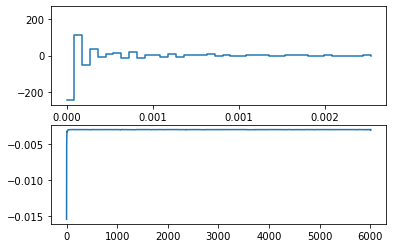

1


<Figure size 1008x360 with 0 Axes>

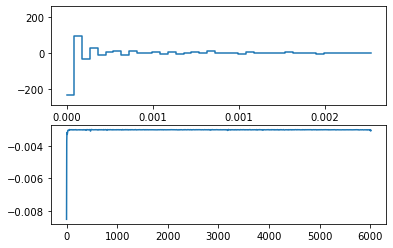

2


<Figure size 1008x360 with 0 Axes>

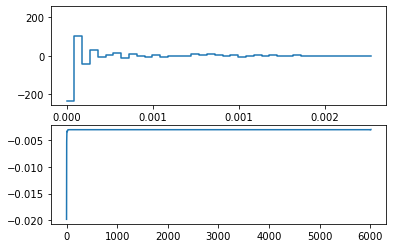

3


<Figure size 1008x360 with 0 Axes>

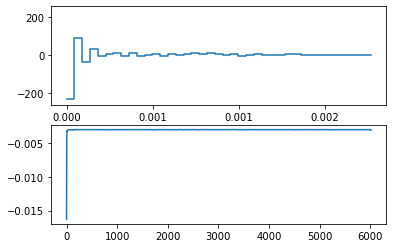

4


<Figure size 1008x360 with 0 Axes>

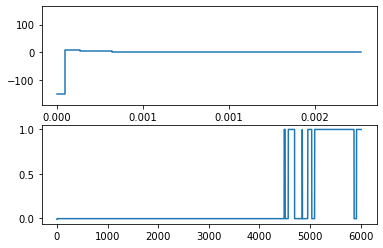

5


<Figure size 1008x360 with 0 Axes>

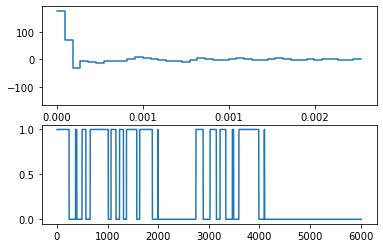

In [67]:
def plot_outputs(input_list, labels_list, output_hat, sample_rate = 22050):
    num_samples = input_list.size()[0]
    diff_labels = labels_list - output_hat
    for i in range(num_samples):
        print(i)
        plt.figure(figsize=(14,5))
        fig,(ax1,ax2) = plt.subplots(2,1)
        librosa.display.waveshow(input_list[i].numpy(),sample_rate,ax = ax1)
        ax2.plot(diff_labels[i].numpy())
        plt.show()
    return    
    
    
with torch.no_grad():
    plot_outputs(input_list,labels_list,output_hat)

tensor(144.9933, grad_fn=<SumBackward0>)

In [ ]:
filepath = '/project/graziul/ra/ajays/trimmed_threshold_plots/frame_error_rate_52.png'
import matplotlib.image as img
my_img = img.imread(filepath)
plt.imshow(my_img)